In [1]:
# from google.colab import drive
#drive.mount('/content/gdrive')

In [1]:
import os
import cv2
from sklearn.utils import shuffle
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator






In [2]:
labels = '/Users/codyyu/Desktop/EE267/Project/archive/meta/meta/labels.txt'
classes = '/Users/codyyu/Desktop/EE267/Project/archive/meta/meta/classes.txt'
dataset_path = '/Users/codyyu/Desktop/EE267/Project/archive/images'
label_map = {}


In [3]:
label_map_reverse = {}

In [4]:
train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2)

test_data_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)
    

In [5]:
batch_size = 32

img_height = 224
img_width = 224

In [7]:
train_data = train_data_generator.flow_from_directory(
    dataset_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = test_data_generator.flow_from_directory(
    dataset_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam



In [14]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [15]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [19]:
def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    # x = inputs
    model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam()
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


In [21]:
model = build_model(num_classes=101)

    
model.summary()
hist = model.fit(train_data, batch_size=60, epochs = 8, validation_data=val_data, verbose=1)
plot_hist(hist)

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['img_augmentation[3][0]']       
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_3[0][0]'] 

                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_b

 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
          

                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation) 

KeyboardInterrupt: 

In [8]:
# np.save('/Users/codyyu/Desktop/EE267/Project/archive/meta/meta/Images.npy',Img_np) # save raw data as numpy array for faster load
# np.save ('/Users/codyyu/Desktop/EE267/Project/archive/meta/meta/Labels.npy',Label_np)
loaded_images = np.load('/Users/codyyu/Desktop/EE267/Project/archive/meta/meta/Images.npy')
loaded_labels = np.load('/Users/codyyu/Desktop/EE267/Project/archive/meta/meta/Labels.npy')

In [9]:
print(loaded_images.shape)
print(loaded_labels.shape)

(101000, 224, 224, 3)
(101000,)


In [10]:
for l in label_map:
    label_map_reverse[label_map[l]] = l

    

In [11]:
def get_classlabel(class_code):

    return label_map_reverse[class_code]

{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000, 10: 1000, 11: 1000, 12: 1000, 13: 1000, 14: 1000, 15: 1000, 16: 1000, 17: 1000, 18: 1000, 19: 1000, 20: 1000, 21: 1000, 22: 1000, 23: 1000, 24: 1000, 25: 1000, 26: 1000, 27: 1000, 28: 1000, 29: 1000, 30: 1000, 31: 1000, 32: 1000, 33: 1000, 34: 1000, 35: 1000, 36: 1000, 37: 1000, 38: 1000, 39: 1000, 40: 1000, 41: 1000, 42: 1000, 43: 1000, 44: 1000, 45: 1000, 46: 1000, 47: 1000, 48: 1000, 49: 1000, 50: 1000, 51: 1000, 52: 1000, 53: 1000, 54: 1000, 55: 1000, 56: 1000, 57: 1000, 58: 1000, 59: 1000, 60: 1000, 61: 1000, 62: 1000, 63: 1000, 64: 1000, 65: 1000, 66: 1000, 67: 1000, 68: 1000, 69: 1000, 70: 1000, 71: 1000, 72: 1000, 73: 1000, 74: 1000, 75: 1000, 76: 1000, 77: 1000, 78: 1000, 79: 1000, 80: 1000, 81: 1000, 82: 1000, 83: 1000, 84: 1000, 85: 1000, 86: 1000, 87: 1000, 88: 1000, 89: 1000, 90: 1000, 91: 1000, 92: 1000, 93: 1000, 94: 1000, 95: 1000, 96: 1000, 97: 1000, 98: 1000, 99: 1000, 100: 1000

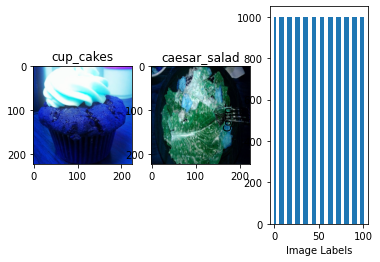

In [12]:
from random import randint
import matplotlib.pyplot as plt
fig,ax= plt.subplots(1,3)
for i in range(0,2):
    rnd_number= randint(0,len(loaded_labels))
    ax[i].imshow(loaded_images[rnd_number])
    ax[i].set_title(get_classlabel(loaded_labels[rnd_number]))
label_values, count = np.unique(loaded_labels,return_counts= True)
distribution = dict(zip(label_values, count))
plt.bar(list(distribution.keys()), distribution.values(),width = 0.6)
plt.xlabel('Image Labels')
plt.ylabel('Count')
plt.show
print(distribution)

CNN Training 

In [13]:
from sklearn.datasets import fetch_openml
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from random import randint

Split train and test data

(75749, 224, 224, 3) (14429, 224, 224, 3) (10822, 224, 224, 3)
(75749,) (14429,) (10822,)


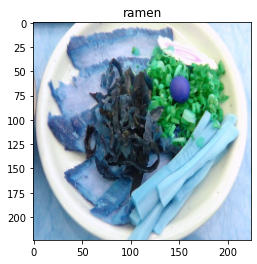

In [14]:
rnd_number = randint(0,len(loaded_labels))
plt.imshow(loaded_images[rnd_number])
plt.title(get_classlabel(loaded_labels[rnd_number]))
X_train, X_test, y_train, y_test = train_test_split(loaded_images, loaded_labels, test_size = 1/7, random_state = 42 )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/8, random_state = 42 )
print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)
np.save('/Users/codyyu/Desktop/EE267/Project/archive/meta/meta/X_test_data.npy',X_test)
np.save('/Users/codyyu/Desktop/EE267/Project/archive/meta/meta/y_test_data.npy',y_test)

In [15]:
np.save('/Users/codyyu/Desktop/EE267/Project/archive/meta/meta/X_val_data.npy',X_val)
np.save('/Users/codyyu/Desktop/EE267/Project/archive/meta/meta/y_val_data.npy',y_val)

In [16]:
np.save('/Users/codyyu/Desktop/EE267/Project/archive/meta/meta/X_train_data.npy',X_train)
np.save('/Users/codyyu/Desktop/EE267/Project/archive/meta/meta/y_train_data.npy',y_train)